In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import copy, deepcopy 

import sys
import os
sys.path.insert(0, os.path.abspath('../model'))

import Pacejka52_glSA as pa52gl

sys.path.insert(0, os.path.abspath('../model/parameter'))
import Pacejka_Params_Indy as pa

#Pacejka 5.2 (2002) pure logitudinal with IA

params_Indy=[pa.PVY1, pa.PVY2, pa.PVY3, pa.PVY4, pa.PKY1, pa.PKY2, pa.PKY3, pa.PKY4, pa.PKY5,pa.PKY6, pa.PKY7, pa.PHY1, pa.PHY2, pa.PCY1, pa.PDY1, pa.PDY2, pa.PDY3, pa.PEY1, pa.PEY2, pa.PEY3, pa.PEY4, pa.PEY5, pa.LMUY, pa.LEY]                  

i=200
alpha=np.linspace(-0.3,0.3,i)
IA=0
Fz0=3114 #nominal load (z.b 80% von Fzmax)

In [9]:
#Sy = np.linspace(-1,1,1000)
#params_Indy = [pa.PHX1, pa.PHX2, pa.PKX1, pa.PKX2, pa.PKX3, pa.PCX1, pa.PDX1, pa.PDX2, pa.PDX3, pa.PEX1, pa.PEX2, pa.PEX4, pa.PVX1, pa.PVX2, pa.LMUX, pa.LEX]
#F = pa52gl.Pacejka52_long(Sy,4000,3114, *params_Indy)[0]
#params_Indy_10=[pa.PHX1, pa.PHX2, pa.PKX1 *1.5, pa.PKX2, pa.PKX3, pa.PCX1, pa.PDX1, pa.PDX2, pa.PDX3, pa.PEX1, pa.PEX2, pa.PEX4, pa.PVX1, pa.PVX2, pa.LMUX, pa.LEX]
#F_10 =pa52gl.Pacejka52_long(Sy,4000,3114, *params_Indy_10)[0]


#plt.plot(Sy,F)
#plt.plot(Sy,F_10,'r--')

In [10]:
#Vergleichsgrößen

def Fy_intervall(Fz,Fy_intv,params,IA): #Fz in [kN], Fx_intv in % (z.b 10% von Fx_max)
#x Position von Fx_max berechnen
    Fy_w=pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0]
    w=len(Fy_w)
    Fy_max_pos=0
    for j in range(0,w):
        if Fy_w[j] == np.max(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0]):
            break
        else:
            Fy_max_pos = Fy_max_pos + 1

    #cut slop
    cut = int(w/2)
    Fy_w_pos = Fy_w[cut::]
    Fy_w_pos_max=Fy_w_pos[0:((Fy_max_pos-cut)+1)] #von 0 bis Fx_max
    Fy_w_max_end=Fy_w_pos[((Fy_max_pos-cut)+1)::] #von Fx_max bis Ende(+100% slipratio)

    Fy_max_ref = np.max(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0]) * Fy_intv #Referenzwert Fx 10% weniger als Fx_max

    left=0
    j=0
    for j in range(0,len(Fy_w_pos_max)):
        if Fy_w_pos_max[j] < Fy_max_ref:
            left +=1
        else:
            break
        
    right = 0
    j=0
    for j in range(0,len(Fy_w_max_end)):
        if Fy_w_max_end[j] > Fy_max_ref:
            right +=1
        else:
            break
        
#Intervall 10% abweichung von Fx_max = [left,right]
    Fy_max_10=Fy_w[cut+left:cut+len(Fy_w_pos_max)+right]
    Fy_slope_b=((len(Fy_w_pos_max)+right)-left)/(cut/100) #breite des Intervalls in %Schlupf
    
    return Fy_slope_b,Fy_max_10,cut,left,right,Fy_w_pos_max


steps=11
Fz_arr1=np.linspace(8000,18000,steps) #von 1kN bis 10kN Fz
Fz_arr=np.round(Fz_arr1,5)

Fy_max_arr = np.zeros((steps,))
Start_slope = np.zeros((steps,))
Dy_max = np.zeros((steps,))
Fy_intv_arr = np.zeros((steps,))
Fy_max_slip_arr = np.zeros((steps,))

plt.figure
i=0

#Schräglaufsteifigkeit

def diff_Pacejka(y,SL): #y = Funktion die abgleitet werden soll, Sl = linspace
    dx = SL[1]-SL[0]
    dydx = np.gradient(y, dx)
    return dydx
    

In [11]:
#größen für lokale SA

s = 0.1 #10% änderung
params_SA = deepcopy(params_Indy)
Fz = 4000 #[N]

Text(0.5, 1.0, 'lokale SA Fy_max, Parameter -10% ')

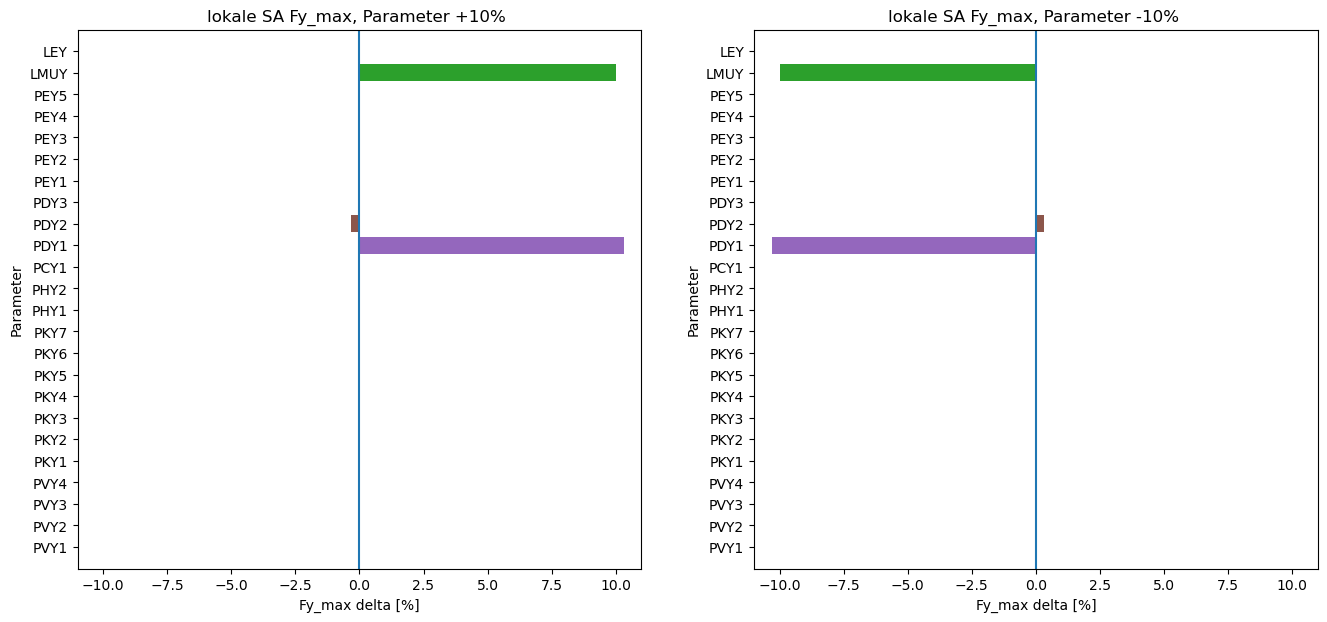

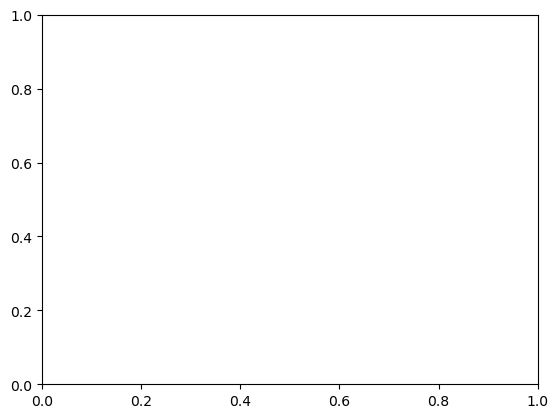

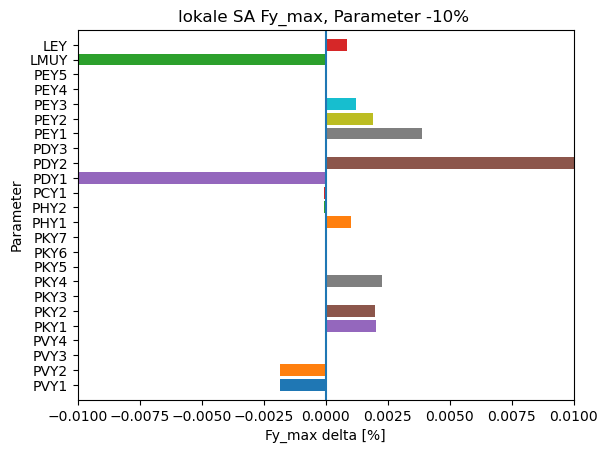

In [12]:
### lokale Sensitivität

#Fx_max#Fz = 4000N, IA = 0.1°
i=0
pramas_Set=params_SA
params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_Fx_max_pos = (np.max(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0]) - np.max(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params_pos)[0]))/np.max(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0])
    params_pos[i] = params[i]
    
    params_neg[i] = params_neg[i]*(1-s)
    delta_Fx_max_neg = (np.max(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0]) - np.max(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params_neg)[0]))/np.max(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0])
    params_neg[i] = params[i]
    
    delta[i] = [delta_Fx_max_neg*100, delta_Fx_max_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0


#Plots params -10%
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
y_axis=( 'PVY1', 'PVY2', 'PVY3', 'PVY4', 'PKY1', 'PKY2', 'PKY3', 'PKY4', 'PKY5', 'PKY6', 'PKY7', 'PHY1', 'PHY2', 'PCY1', 'PDY1', 'PDY2', 'PDY3', 'PEY1', 'PEY2', 'PEY3', 'PEY4', 'PEY5', 'LMUY', 'LEY')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax1.barh(y_pos[i],delta_neg[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-11,11)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Fy_max delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('lokale SA Fy_max, Parameter +10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('PVY1', 'PVY2', 'PVY3', 'PVY4', 'PKY1', 'PKY2', 'PKY3', 'PKY4', 'PKY5', 'PKY6', 'PKY7', 'PHY1', 'PHY2', 'PCY1', 'PDY1', 'PDY2', 'PDY3', 'PEY1', 'PEY2', 'PEY3', 'PEY4', 'PEY5', 'LMUY', 'LEY')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax2.barh(y_pos[i],delta_pos[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-11,11)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Fy_max delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('lokale SA Fy_max, Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('PVY1', 'PVY2', 'PVY3', 'PVY4', 'PKY1', 'PKY2', 'PKY3', 'PKY4', 'PKY5', 'PKY6', 'PKY7', 'PHY1', 'PHY2', 'PCY1', 'PDY1', 'PDY2', 'PDY3', 'PEY1', 'PEY2', 'PEY3', 'PEY4', 'PEY5', 'LMUY', 'LEY')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-0.01,0.01)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Parameter")
plt.title('lokale SA Fy_max, Parameter -10% ')


In [13]:
F = pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0]

Text(0.5, 1.0, 'lokale SA,alpha bei Fy_max, Parameter +10% ')

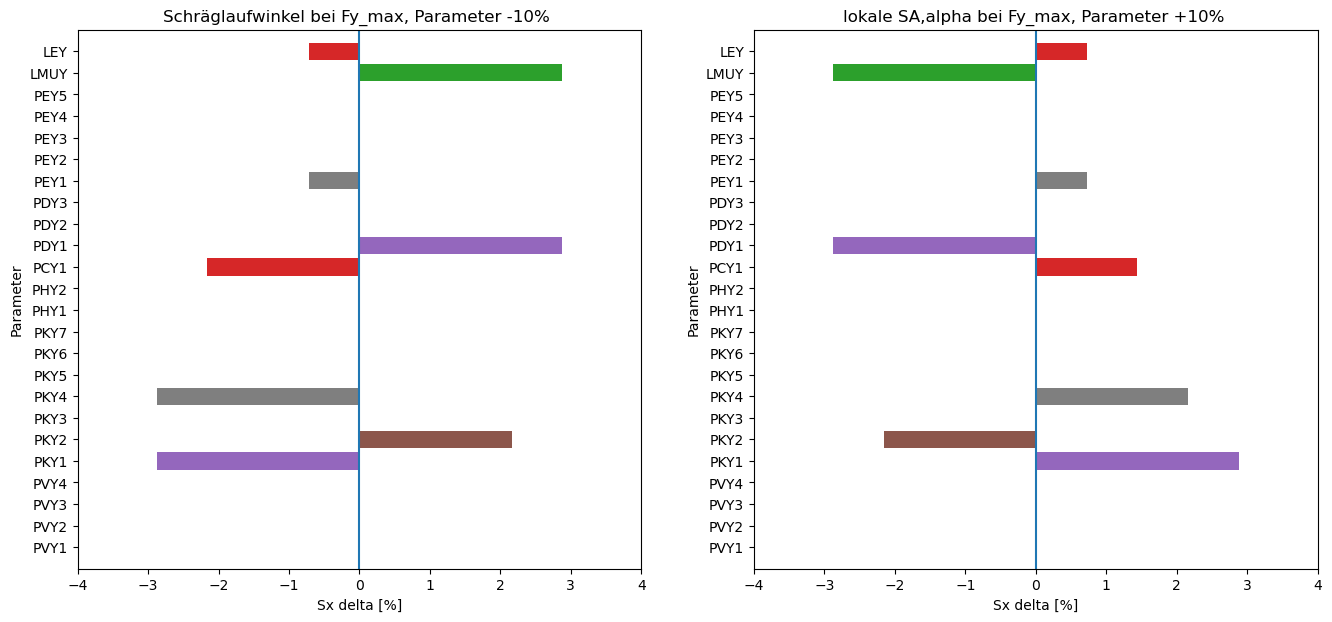

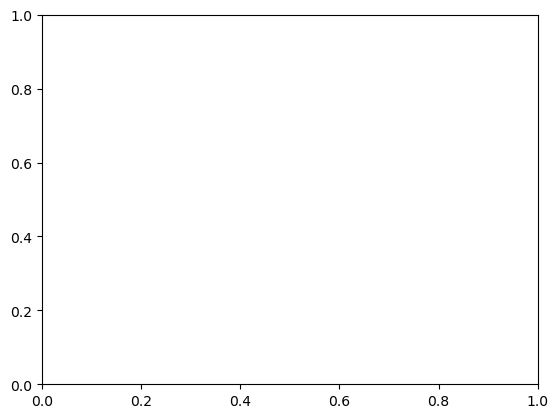

In [18]:
#alpha bei max Fy

#Fy_max#Fz = 4000N, IA = 0.1°
i=0
pramas_Set=params_SA


params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (np.argmax(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0]) - np.argmax(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params_pos)[0]))/(np.argmax(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0]))
    params_pos[i] = params[i]
   
    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (np.argmax(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0]) - np.argmax(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params_neg)[0]))/(np.argmax(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0]))
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0

#Plots params -10%
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
y_axis=('PVY1', 'PVY2', 'PVY3', 'PVY4', 'PKY1', 'PKY2', 'PKY3', 'PKY4', 'PKY5', 'PKY6', 'PKY7', 'PHY1', 'PHY2', 'PCY1', 'PDY1', 'PDY2', 'PDY3', 'PEY1', 'PEY2', 'PEY3', 'PEY4', 'PEY5', 'LMUY', 'LEY')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax1.barh(y_pos[i],delta_neg[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-4,4)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Sx delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('Schräglaufwinkel bei Fy_max, Parameter -10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('PVY1', 'PVY2', 'PVY3', 'PVY4', 'PKY1', 'PKY2', 'PKY3', 'PKY4', 'PKY5', 'PKY6', 'PKY7', 'PHY1', 'PHY2', 'PCY1', 'PDY1', 'PDY2', 'PDY3', 'PEY1', 'PEY2', 'PEY3', 'PEY4', 'PEY5', 'LMUY', 'LEY')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax2.barh(y_pos[i],delta_pos[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-4,4)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Sx delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('lokale SA,alpha bei Fy_max, Parameter +10% ')

Text(0.5, 1.0, '90 % Intervall, Parameter -10% ')

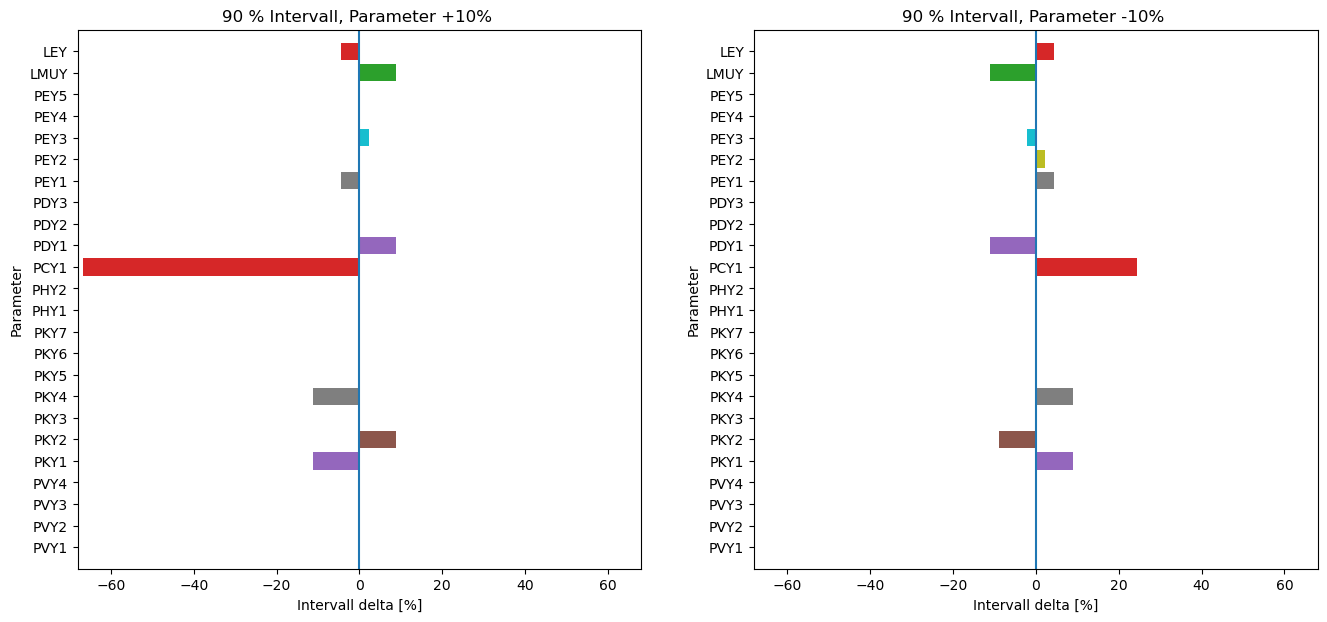

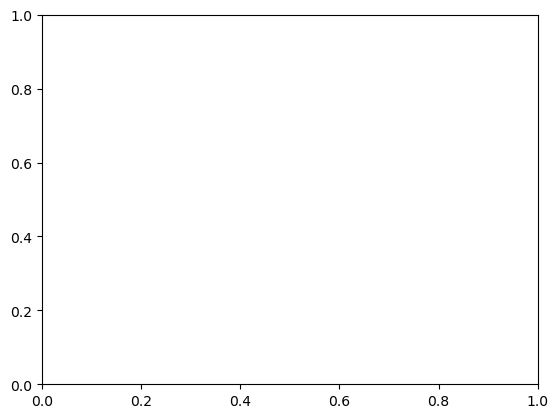

In [15]:
#alpha Intervall (10% von Fx max)

#Fy_max, IA = 0.1°
i=0


pramas_Set=params_SA


params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = deepcopy(pramas_Set)
params_neg = deepcopy(pramas_Set)
i=0

#params = params_Indy
#params_pos = np.zeros(len(params))
#params_neg = np.zeros(len(params))
delta=np.zeros((len(params),2))

for i in range(0,len(params)):
    
    params_pos[i] = params[i]*(1+s)
    delta_pos = (Fy_intervall(Fz,0.9,params,IA)[0] - Fy_intervall(Fz,0.9,params_pos,IA)[0])/(Fy_intervall(Fz,0.9,params,IA)[0])
    #print(Fy_intervall(Fz,0.9,params,IA)[0])
    #print(Fy_intervall(Fz,0.9,params_pos,IA)[0])
    params_pos[i] = params[i]

    params_neg[i] = params[i]*(1-s)
    delta_neg = (Fy_intervall(Fz,0.9,params,IA)[0] - Fy_intervall(Fz,0.9,params_neg,IA)[0])/(Fy_intervall(Fz,0.9,params,IA)[0])
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]


i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0


#Plots params -10%
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
y_axis=('PVY1', 'PVY2', 'PVY3', 'PVY4', 'PKY1', 'PKY2', 'PKY3', 'PKY4', 'PKY5', 'PKY6', 'PKY7', 'PHY1', 'PHY2', 'PCY1', 'PDY1', 'PDY2', 'PDY3', 'PEY1', 'PEY2', 'PEY3', 'PEY4', 'PEY5', 'LMUY', 'LEY')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax1.barh(y_pos[i],delta_neg[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-68,68)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Intervall delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('90 % Intervall, Parameter +10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('PVY1', 'PVY2', 'PVY3', 'PVY4', 'PKY1', 'PKY2', 'PKY3', 'PKY4', 'PKY5', 'PKY6', 'PKY7', 'PHY1', 'PHY2', 'PCY1', 'PDY1', 'PDY2', 'PDY3', 'PEY1', 'PEY2', 'PEY3', 'PEY4', 'PEY5', 'LMUY', 'LEY')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax2.barh(y_pos[i],delta_pos[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-68,68)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Intervall delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('90 % Intervall, Parameter -10% ')

Text(0.5, 1.0, 'lokale SA, Schräglaufsteifigkeit, Parameter -10% ')

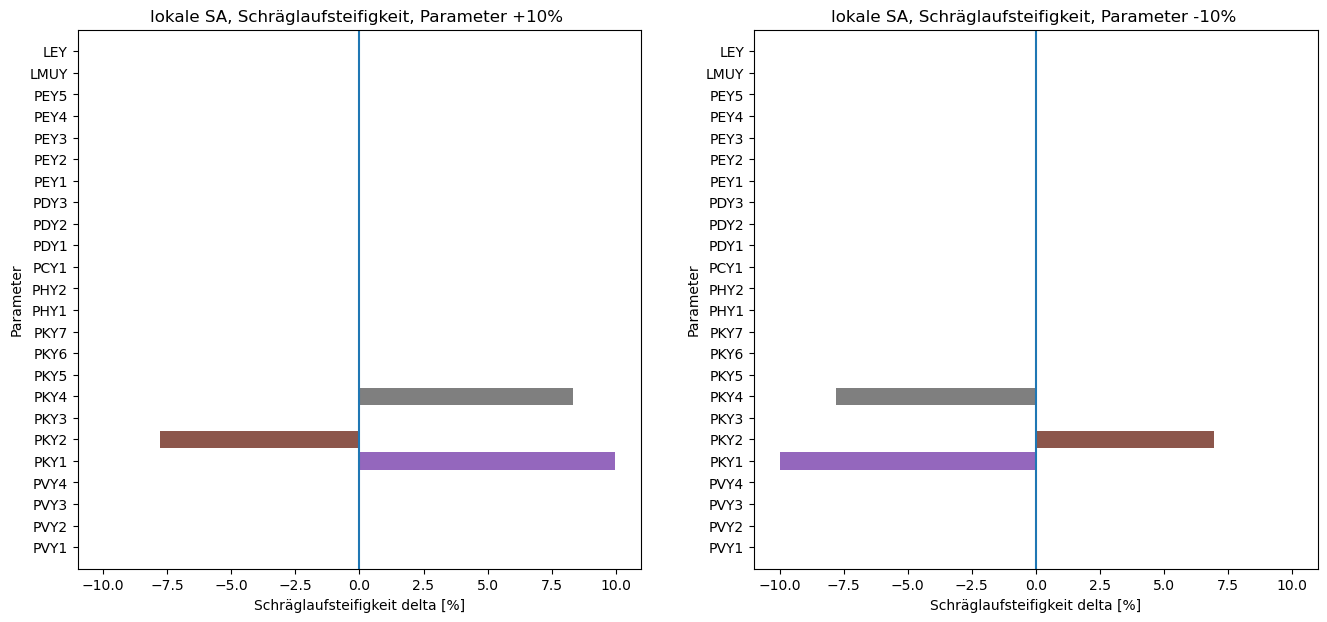

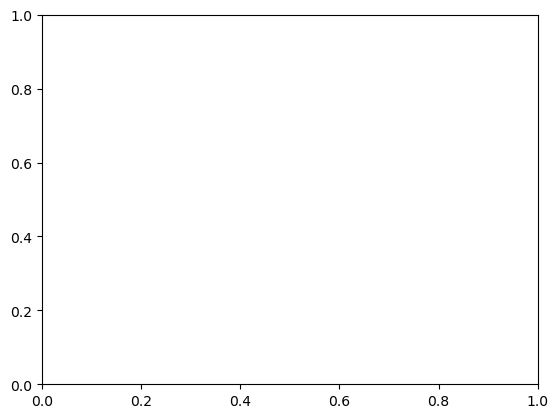

In [16]:
#Schräglaufsteifigkeit 

#Fy_max#Fz = 4000N, IA = 0.1°
i=0
IA =0
pramas_Set=params_SA
Fz = 5000

params=np.zeros((len(pramas_Set),))

for i in range(0,len(pramas_Set)):
    params[i]=params_Indy[i]
    
params_pos = pramas_Set
params_neg = pramas_Set
i=0

delta=np.zeros((len(params),2))
iter = len(alpha)/2
for i in range(0,len(params)):
    
    params_pos[i] = params_pos[i]*(1+s)
    delta_pos = (diff_Pacejka(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0],alpha)[int(iter)] - diff_Pacejka(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params_pos)[0],alpha)[int(iter)])/diff_Pacejka(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0],alpha)[int(iter)]
    params_pos[i] = params[i]

    params_neg[i] = params_neg[i]*(1-s)
    delta_neg = (diff_Pacejka(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0],alpha)[int(iter)] - diff_Pacejka(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params_neg)[0],alpha)[int(iter)])/diff_Pacejka(pa52gl.Pacejka52_lat(alpha,Fz,Fz0, *params)[0],alpha)[int(iter)]
    params_neg[i] = params[i]
    
    delta[i] = [delta_neg*100, delta_pos*100]
    
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,len(params)):
    delta_pos[i,0] = 0

i=0
for i in range(0,len(params)):
    delta_neg[i,1] = 0



#Plots params -10%
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
y_axis=('PVY1', 'PVY2', 'PVY3', 'PVY4', 'PKY1', 'PKY2', 'PKY3', 'PKY4', 'PKY5', 'PKY6', 'PKY7', 'PHY1', 'PHY2', 'PCY1', 'PDY1', 'PDY2', 'PDY3', 'PEY1', 'PEY2', 'PEY3', 'PEY4', 'PEY5', 'LMUY', 'LEY')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax1.barh(y_pos[i],delta_neg[i])
ax1.set_yticks(y_pos, labels=y_axis)
ax1.set_xlim(-11,11)
ax1.set_ylim(-1,len(y_axis))
ax1.axvline(0, 0, 1)
ax1.set_xlabel("Schräglaufsteifigkeit delta [%]")
ax1.set_ylabel("Parameter")
ax1.set_title('lokale SA, Schräglaufsteifigkeit, Parameter +10% ')

#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('PVY1', 'PVY2', 'PVY3', 'PVY4', 'PKY1', 'PKY2', 'PKY3', 'PKY4', 'PKY5', 'PKY6', 'PKY7', 'PHY1', 'PHY2', 'PCY1', 'PDY1', 'PDY2', 'PDY3', 'PEY1', 'PEY2', 'PEY3', 'PEY4', 'PEY5', 'LMUY', 'LEY')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax2.barh(y_pos[i],delta_pos[i])
ax2.set_yticks(y_pos, labels=y_axis)
ax2.set_xlim(-11,11)
ax2.set_ylim(-1,len(y_axis))
ax2.axvline(0, 0, 1)
ax2.set_xlabel("Schräglaufsteifigkeit delta [%]")
ax2.set_ylabel("Parameter")
ax2.set_title('lokale SA, Schräglaufsteifigkeit, Parameter -10% ')



In [17]:
#Sturzabhängigkeit auf Fy Max

IA = np.linspace(-2,2,10)

i=0
Fz=4000
plt.figure
#x=np.zeros((,len(IA)))
for i in range(0,len(IA)):
    plt.plot(alpha,Pacejka5_2(14000,alpha,IA[i],Fz0,params_Indy)[0])
    
   # x[i]=Pacejka5_2(4000,SL,IA[i],Fz0,params_Indy)[0]

x=(Pacejka5_2(4000,alpha,IA[0],Fz0,params_PKW)[0]-Pacejka5_2(4000,alpha,IA[1],Fz0,params_PKW)[0])[0]
#print(x)
#print(IA*np.pi/180)

plt.figure
i=0
for i in range(0,len(IA)):
    plt.plot(alpha,Pacejka5_2(14000,alpha,IA[i],Fz0,params_Indy)[0])

    
    
IA = 1 #Referenzwert


    
IA_pos = deepcopy(IA)
IA_neg = deepcopy(IA)
i=0

delta=np.zeros((4,2))

#Fx_max
IA_pos = IA_pos*(1+s)
delta_Fx_max_pos = (np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]) - np.max(Pacejka5_2(Fz,alpha,IA_pos,Fz0,params_SA)[0]))/np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0])
IA_pos = IA
    
IA_neg = IA_neg*(1-s)
delta_Fx_max_neg = (np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]) - np.max(Pacejka5_2(Fz,alpha,IA_neg,Fz0,params_SA)[0]))/np.max(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0])
IA_neg = IA
    


#alpha bei Fx_max
i=1
IA_pos = IA_pos*(1+s)
delta_pos = (np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]) - np.argmax(Pacejka5_2(Fz,alpha,IA_pos,Fz0,params_SA)[0]))/(np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]))
IA_pos = IA
   
IA_neg = IA_neg*(1-s)
delta_neg = (np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]) - np.argmax(Pacejka5_2(Fz,alpha,IA_neg,Fz0,params_SA)[0]))/(np.argmax(Pacejka5_2(Fz,alpha,IA,Fz0,params_SA)[0]))
IA_neg = IA
    
delta[1] = [delta_neg*100, delta_pos*100]

#Intervall
i=2
IA_pos = IA_pos*(1+s)
delta_pos = (Fy_intervall(Fz,2,params_SA,IA)[0] - Fy_intervall(Fz,0.9,params_SA,IA_pos)[0])/(Fy_intervall(Fz,0.9,params_SA,IA)[0])
IA_pos = IA

IA_neg = IA_neg*(1-s)
delta_neg = (Fy_intervall(Fz,0.9,params_SA,IA)[0] - Fy_intervall(Fz,0.9,params_SA,IA_neg)[0])/(Fy_intervall(Fz,0.9,params_SA,IA)[0])
IA_neg = IA
    
delta[2] = [delta_neg*100, delta_pos*100]

#Schräglaufsteifigkeit
i=3
IA_pos = IA_pos*(1+s)
delta_pos = (slope(Fz,params_SA,IA) - slope(Fz,params_SA,IA_pos))/(slope(Fz,params_SA,IA))
IA_pos = IA

IA_neg = IA_neg*(1-s)
delta_neg = (slope(Fz,params_SA,IA) - slope(Fz,params_SA,IA_neg))/(slope(Fz,params_SA,IA))
IA_neg = IA
    
delta[3] = [delta_neg*100, delta_pos*100]

print(delta)
i=0
delta_neg = deepcopy(delta)
delta_pos = deepcopy(delta)
for i in range(0,4):
    delta_pos[i,0] = 0

i=0
for i in range(0,4):
    delta_neg[i,1] = 0

print(delta_pos)
print(delta_pos)
#Plots params -10%
fig, ax = plt.subplots()
y_axis=('Fx max', 'Alpha bei Fx max', 'Intervall 90% Fx max', 'Schräglaufsteifigkeit')
y_pos=np.arange(len(y_axis))
i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_neg[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-2.5,2.5)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("Fz [N]")
plt.title('lokale SA, IA (10% von IA ref), Parameter -10% ')


#Plots params +10%
fig, ax = plt.subplots()
#print(delta_neg)
y_axis=('Fx max', 'Alpha bei Fx max', 'Intervall 90% Fx max', 'Schräglaufsteifigkeit')
y_pos=np.arange(len(y_axis))

i=0
for i in range(0,len(y_pos)):
    ax.barh(y_pos[i],delta_pos[i])
ax.set_yticks(y_pos, labels=y_axis)
plt.xlim(-2.5,2.5)
plt.ylim(-1,len(y_axis))
plt.axvline(0, 0, 1)
plt.xlabel("Fy_max delta [%]")
plt.ylabel("IA [°]")
plt.title('lokale SA, IA (10% von IA ref), Parameter +10% ')

NameError: name 'Pacejka5_2' is not defined

In [ ]:
a=slope(5000,params_Indy,0)
print(a)

1.5707880914763808
